In [22]:
import torch
import torch.nn
import torchvision

from torch import nn
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter
from PIL import Image

import matplotlib.pyplot as plt
 
import os
import random
import shutil
print(f"torch version : {torch.__version__}")

torch version : 2.0.0


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from pytorch_modules.pytorch_modules import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/DutchVandaline/Artificial_Intelligence.git
    !mv Artificial_Intelligence/pytorch_modules .
    !mv Artificial_Intelligence/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from pytorch_modules.pytorch_modules import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [23]:
writer = SummaryWriter(log_dir="TensorBoard/SwinTransformer_Tiny_log")

In [4]:
augmented_images_dir = "C:\junha\Personal_Notebook\oversampling_data"

In [5]:
def walk_through_dir(dir_path):
    """ Walks through dir_path returning its conents."""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directoreis and {len(filenames)} images in '{dirpath}'.")
walk_through_dir(augmented_images_dir)

There are 3 directoreis and 0 images in 'C:\junha\Personal_Notebook\oversampling_data'.
There are 2 directoreis and 0 images in 'C:\junha\Personal_Notebook\oversampling_data\test'.
There are 0 directoreis and 393 images in 'C:\junha\Personal_Notebook\oversampling_data\test\defect'.
There are 0 directoreis and 353 images in 'C:\junha\Personal_Notebook\oversampling_data\test\normal'.
There are 2 directoreis and 0 images in 'C:\junha\Personal_Notebook\oversampling_data\train'.
There are 0 directoreis and 1569 images in 'C:\junha\Personal_Notebook\oversampling_data\train\defect'.
There are 0 directoreis and 1409 images in 'C:\junha\Personal_Notebook\oversampling_data\train\normal'.
There are 2 directoreis and 0 images in 'C:\junha\Personal_Notebook\oversampling_data\z_keep_out_for_final_test'.
There are 0 directoreis and 20 images in 'C:\junha\Personal_Notebook\oversampling_data\z_keep_out_for_final_test\defect'.
There are 0 directoreis and 20 images in 'C:\junha\Personal_Notebook\oversamp

In [6]:
oversampling_train_dir = "C:/junha/Personal_Notebook/oversampling_data/train"
oversampling_test_dir = "C:/junha/Personal_Notebook/oversampling_data/test"

In [7]:
swinTransformer_tiny_weights = torchvision.models.Swin_V2_T_Weights.DEFAULT
swinTransformer_Tiny = torchvision.models.swin_v2_t(weights=swinTransformer_tiny_weights)

for parameter in swinTransformer_Tiny.parameters():
  parameter.requires_grad = False

set_seeds()
swinTransformer_Tiny.head = nn.Linear(in_features=768, out_features=2).to(device)

In [8]:
swinTransformer_Tiny

SwinTransformer(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): Permute()
      (2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (1): Sequential(
      (0): SwinTransformerBlockV2(
        (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (attn): ShiftedWindowAttentionV2(
          (qkv): Linear(in_features=96, out_features=288, bias=True)
          (proj): Linear(in_features=96, out_features=96, bias=True)
          (cpb_mlp): Sequential(
            (0): Linear(in_features=2, out_features=512, bias=True)
            (1): ReLU(inplace=True)
            (2): Linear(in_features=512, out_features=3, bias=False)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (0): Linear(in_features=96, out_features=384, bias=True)
          (1): GELU(approximate='

In [9]:
# Create an instance of Transformerblock
summary(model=swinTransformer_Tiny,
        input_size = (1,3,2532,824),
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 16,
        row_settings=["var_names"])

Layer (type (var_name))                                 Input Shape      Output Shape     Param #          Trainable
SwinTransformer (SwinTransformer)                       [1, 3, 2532, 824] [1, 2]           --               Partial
├─Sequential (features)                                 [1, 3, 2532, 824] [1, 80, 26, 768] --               False
│    └─Sequential (0)                                   [1, 3, 2532, 824] [1, 633, 206, 96] --               False
│    │    └─Conv2d (0)                                  [1, 3, 2532, 824] [1, 96, 633, 206] (4,704)          False
│    │    └─Permute (1)                                 [1, 96, 633, 206] [1, 633, 206, 96] --               --
│    │    └─LayerNorm (2)                               [1, 633, 206, 96] [1, 633, 206, 96] (192)            False
│    └─Sequential (1)                                   [1, 633, 206, 96] [1, 633, 206, 96] --               False
│    │    └─SwinTransformerBlockV2 (0)                  [1, 633, 206, 96] [1, 633

In [10]:
# Get the transforms used to create our pretrained weights
manual_transforms = transforms.Compose([
    transforms.Resize((2532, 824)), # normal은 2532임 defect는 2732
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
manual_transforms

Compose(
    Resize(size=(2532, 824), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [18]:
#Set up dataloaders
from pytorch_modules.pytorch_modules import data_setup
oversampling_train_dataloader, oversampling_test_dataloader, class_names = data_setup.create_dataloaders(train_dir=oversampling_train_dir,
                                                                                                     test_dir=oversampling_test_dir,
                                                                                                     transform=manual_transforms,
                                                                                                    num_workers=0,
                                                                                                     pin_memory=False,
                                                                                                     batch_size=16)
len(class_names)

2

In [19]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(swinTransformer_Tiny.parameters(), lr= 0.001)

In [20]:
device

'cuda'

In [27]:
from pytorch_modules.pytorch_modules import engine

from timeit import default_timer as timer
start_time = timer()

results = engine.train(model=swinTransformer_Tiny,
                       train_dataloader=oversampling_train_dataloader,
                       test_dataloader =oversampling_test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time: .3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0090 | train_acc: 0.9993 | test_loss: 0.0058 | test_acc: 1.0000
Epoch: 2 | train_loss: 0.0087 | train_acc: 0.9987 | test_loss: 0.0043 | test_acc: 1.0000
Epoch: 3 | train_loss: 0.0062 | train_acc: 0.9993 | test_loss: 0.0058 | test_acc: 1.0000
Epoch: 4 | train_loss: 0.0048 | train_acc: 0.9997 | test_loss: 0.0024 | test_acc: 1.0000
Epoch: 5 | train_loss: 0.0044 | train_acc: 0.9997 | test_loss: 0.0024 | test_acc: 1.0000
Epoch: 6 | train_loss: 0.0035 | train_acc: 1.0000 | test_loss: 0.0017 | test_acc: 1.0000
Epoch: 7 | train_loss: 0.0028 | train_acc: 1.0000 | test_loss: 0.0020 | test_acc: 1.0000
Epoch: 8 | train_loss: 0.0028 | train_acc: 0.9997 | test_loss: 0.0013 | test_acc: 1.0000
Epoch: 9 | train_loss: 0.0032 | train_acc: 0.9993 | test_loss: 0.0012 | test_acc: 1.0000
Epoch: 10 | train_loss: 0.0036 | train_acc: 0.9997 | test_loss: 0.0009 | test_acc: 1.0000
[INFO] Total training time:  3235.163 seconds


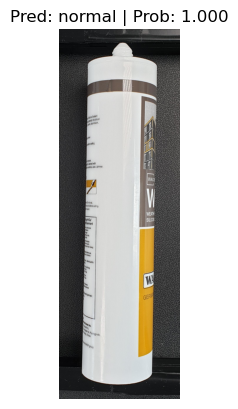

In [28]:
from pytorch_modules.pytorch_modules.predictions import pred_and_plot_image
input_image = "C:/junha/Personal_Notebook/oversampling_data/z_keep_out_for_final_test/normal/20240823_101759.jpg"

pred_and_plot_image(model=swinTransformer_Tiny,
                           image_path=input_image,
                           class_names=class_names,
                            transform=manual_transforms)

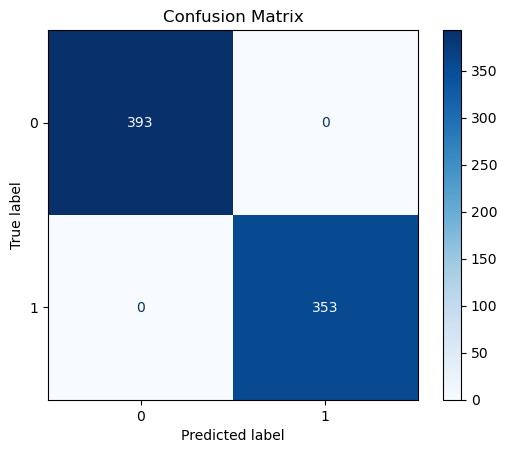

In [29]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Ensure the model is in evaluation mode
swinTransformer_Tiny.eval()

# Create lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Move model to the appropriate device (e.g., CPU or GPU)
swinTransformer_Tiny.to(device)

# Disable gradient calculation for evaluation
with torch.no_grad():
    for data in oversampling_test_dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = swinTransformer_Tiny(inputs)
        _, preds = torch.max(outputs, 1)

        # Collect predictions and true labels
        predicted_labels.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


F1 Score (Micro): 1.0
F1 Score (Macro): 1.0
Total true labels collected: 746
Total predicted labels collected: 746


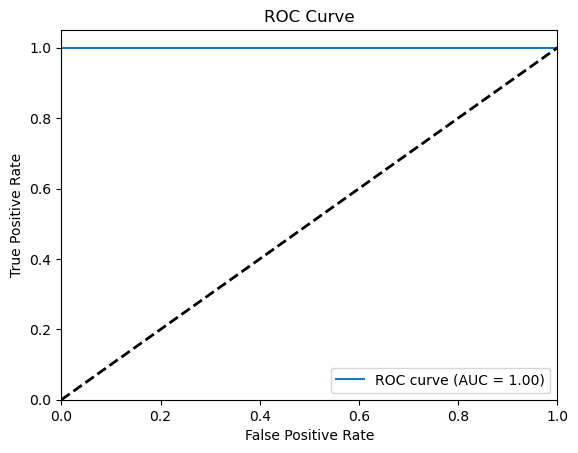

In [30]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_curve, auc
import numpy as np

# Ensure the model is in evaluation mode and move it to the appropriate device
swinTransformer_Tiny.to(device)
swinTransformer_Tiny.eval()

# Create lists to store true and predicted labels
true_labels = []
predicted_labels = []
all_probabilities = []

# Disable gradient calculation for evaluation
with torch.no_grad():
    for data in oversampling_test_dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = swinTransformer_Tiny(inputs)
        _, preds = torch.max(outputs, 1)

        # Collect predictions, true labels, and predicted probabilities
        predicted_labels.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
        all_probabilities.extend(torch.softmax(outputs, dim=1).cpu().numpy())

# Calculate F1 score (micro and macro)
f1_micro = f1_score(true_labels, predicted_labels, average='micro')
f1_macro = f1_score(true_labels, predicted_labels, average='macro')
print(f"F1 Score (Micro): {f1_micro}")
print(f"F1 Score (Macro): {f1_macro}")

# Check if the task is binary classification
if len(np.unique(true_labels)) == 2:
    # Binary classification: Use only one ROC curve
    probabilities_class_1 = np.array(all_probabilities)[:, 1]
    fpr, tpr, thresholds = roc_curve(true_labels, probabilities_class_1)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve for binary classification
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')

# Print total count of true and predicted labels for debugging
print(f"Total true labels collected: {len(true_labels)}")
print(f"Total predicted labels collected: {len(predicted_labels)}")


# Plot settings
plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


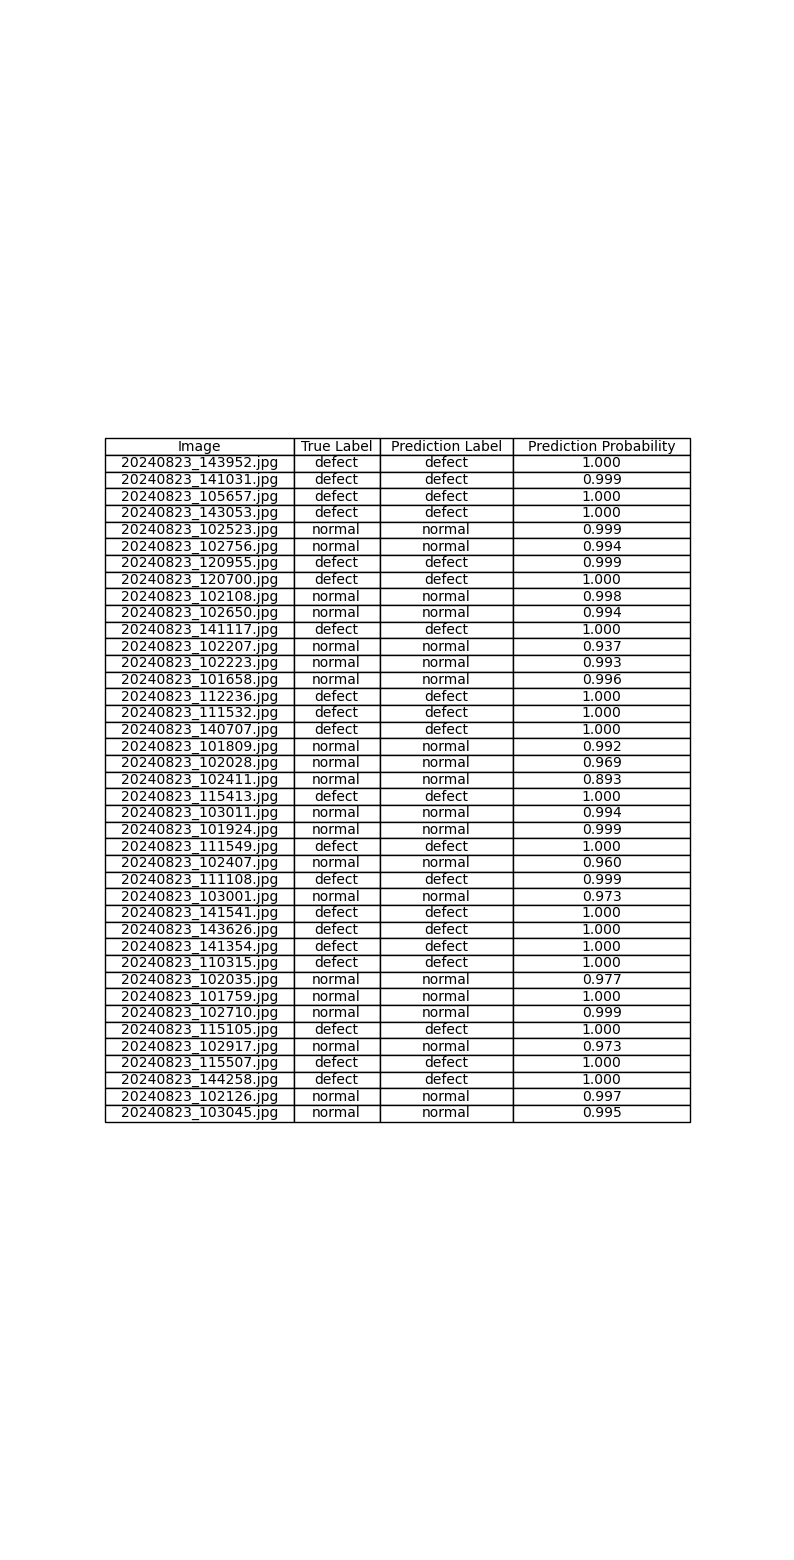

In [31]:
import os
import random
import matplotlib.pyplot as plt
import pandas as pd
from pytorch_modules.pytorch_modules.predictions import pred_and_plot_image

# Define paths to normal and defect images
normal_folder = "C:/junha/Personal_Notebook/oversampling_data/z_keep_out_for_final_test/normal"
defect_folder = "C:/junha/Personal_Notebook/oversampling_data/z_keep_out_for_final_test/defect"

# List all images in normal and defect folders with labels
normal_images = [(os.path.join(normal_folder, img), "normal") for img in os.listdir(normal_folder)]
defect_images = [(os.path.join(defect_folder, img), "defect") for img in os.listdir(defect_folder)]

# Combine and shuffle the images
all_images = normal_images + defect_images
random.shuffle(all_images)

# Initialize list to store predictions
results = []

# Iterate over each image, predict, and store the results
for image_path, true_label in all_images:
    # Predict the label using the model
    pred_and_plot_image(model=swinTransformer_Tiny, image_path=image_path, class_names=class_names, transform=manual_transforms)
    
    # Extract the prediction label and probability from the plot title
    plt_title = plt.gca().get_title()  # Get title containing label and probability
    pred_label = plt_title.split('|')[0].split(': ')[1].strip()
    pred_prob = plt_title.split('|')[1].split(': ')[1].strip()  # No conversion, keep the original
    
    # Append results including true label
    results.append([os.path.basename(image_path), true_label, pred_label, pred_prob])
    
    # Close the plot to manage resources
    plt.close()

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=["Image", "True Label", "Prediction Label", "Prediction Probability"])

# Display results in a table
fig, ax = plt.subplots(figsize=(10, len(results)*0.5))  # Adjust height based on number of rows
ax.axis('off')  # Turn off the axis
table = ax.table(cellText=results_df.values, colLabels=results_df.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(results_df.columns))))

plt.show()